<large>
<b>Purpose & Pipeline</b>

This notebook evaluates machine-learning models to forecast <b>quarterly dwelling starts</b> per province using the prepared dataset <code>data/housing_adequacy_dataset.csv</code>. The target is <code>dwelling_starts</code>; features are selected based on the chosen prediction horizon:

• <b>next_quarter</b> → H=1 (t+1)  
• <b>same_quarter_next_year</b> → H=4 (t+4, same quarter next year)

<b>End-to-end flow:</b>
1. <i>Configuration</i>: Reproducibility, plotting, and library imports.
2. <i>Utilities</i>: Load helper functions from <code>utilities/01_func_dwelling.py</code>.
3. <i>Load & Frame</i>: Read the dataset, build a modeling frame with lags/exogenous drivers.
4. <i>Feature Choice</i>: Select features consistent with the horizon (H).
5. <i>Split</i>: Chronological train/test based on <code>CUTOFF_DATE</code> (train ≤ cutoff, test > cutoff).
6. <i>Tuning</i>: For each model, random/heuristic hyperparameter search (or load cache).
7. <i>Holdout Fit/Pred</i>: Train per-province, predict on test, and compute metrics.
8. <i>Baselines</i>: Add seasonal-naïve baseline for fair MASE comparison.
9. <i>Visualization</i>: Overlays of predictions vs truth; rolling evaluation (evolving cutoff).
10. <i>Diagnostics</i>: Heatmaps of error metrics; province-level leaderboard and ranks.

<b>Key metric:</b> <code>MASE</code> compares a model's forecast errors against the seasonal-naïve baseline (values &lt; 1 mean beating the baseline). We also report MAE, RMSE, and sMAPE.

<b>Notes:</b>
• Housing starts in the CSV were converted from SAAR to quarterly units during preprocessing.  
• Province-level models are trained independently; national aggregation is evaluated from provincial results when needed.  
• Tuning is limited (<code>n_iter</code>) for speed; increase it for deeper searches.
</large>


## Here we use H=4

In [9]:
# ===============================
# Imports & Global Config
# ===============================
import os, json, math, warnings, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from xgboost import XGBRegressor

warnings.filterwarnings("ignore")
plt.rcParams["figure.dpi"] = 140
sns.set_context("notebook")


<large>
<b>Utility Functions</b>

Load all helper utilities (feature construction, tuning, splits, plotting).  
This notebook assumes <code>01_func_dwelling.py</code> provides:
• <code>build_model_frame</code> – assemble features/target  
• <code>features_for_choice</code> – pick feature set + horizon H per choice  
• <code>chrono_split</code> – chronological train/test split  
• <code>load_or_tune_best_params</code> – cache-aware hyperparameter tuning  
• <code>fit_predict_holdout_per_province</code> – per-province fit/predict  
• <code>add_naive_to_holdout</code> – add seasonal naïve baseline  
• <code>plot_holdout_overlay</code>, <code>rolling_evolution_overlay</code>, <code>latest_per_quarter</code>, <code>rolling_overlay_lines</code> – visual diagnostics  
• <code>summarize_metrics_table</code>, <code>plot_perf_heatmaps_from_preds</code>, <code>rank_models_across_provinces</code>, <code>add_row_metrics_for_rolling</code> – scoring & ranking
</large>


In [10]:
%run utilities/01_func_dwelling.py

<large>
<b>Data & Split Configuration</b>

• <code>DATA_PATH</code> points to the prebuilt quarterly dataset with features.  
• <code>CUTOFF_DATE</code> defines the time-based split: train ≤ cutoff, test > cutoff.  
• <code>ALL_MODELS</code> selects which models to train (trim as needed for speed).
</large>

In [11]:

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

# Paths
DATA_PATH  = "data/housing_adequacy_dataset.csv"

# Split
CUTOFF_DATE = "2018-12-31"  # train ≤ cutoff, test > cutoff

# Available models
ALL_MODELS = ["lr", "rf", "ridge", "xgb", "etr"]  # trim as needed

# ===============================
# Choose prediction target here:
# "next_quarter"            -> H=1
# "same_quarter_next_year"  -> H=4
# ===============================

<large>
<b>Horizon Selection</b>

Choose the forecasting horizon:
• <b>next_quarter</b> → H=1 (predict t+1)  
• <b>same_quarter_next_year</b> → H=4 (predict t+4, same quarter next year)

This choice determines the feature set (lags/exogenous) returned by <code>features_for_choice</code> and the forecasting horizon used throughout.
</large>


In [12]:

# ===============================
# Run: load, prep, select features by choice, tune/load cache, evaluate, visualize
# ===============================

PREDICTION_CHOICE = "same_quarter_next_year"  # or "next_quarter"


<large>
<b>Load & Build Modeling Frame</b>

Read the prepared dataset and construct the modeling frame (features + target <code>y</code>).  
The builder handles lag features and required transformations consistently with prior preprocessing.
</large>

In [13]:

# Load + frame
raw = pd.read_csv(DATA_PATH)
model_df = build_model_frame(raw)


<large>
<b>Time Index Normalization</b>

Ensure the <code>quarter</code> column has a proper datetime dtype to support chronological splits and plotting.  
Any parsing failures become NaT (coerced).
</large>


In [14]:

# Ensure datetime dtype
model_df["quarter"] = pd.to_datetime(model_df["quarter"], errors="coerce")


<large>
<b>Feature Set for the Chosen Horizon</b>

Select the horizon (<code>H</code>) and the corresponding feature list (<code>feat_cols</code>) using <code>features_for_choice</code>.  
This keeps experiments comparable across different horizons with consistent inputs.
</large>

In [15]:

# Choose features by prediction choice
H, feat_cols = features_for_choice(PREDICTION_CHOICE)
print(f"Mode: {PREDICTION_CHOICE} | Horizon H={H}")
print("Features:", feat_cols)


Mode: same_quarter_next_year | Horizon H=4
Features: ['dwelling_starts_lag4', 'dwelling_starts_lag8', 'pop_change_q_lag4', 'needed_units_q_lag4']


<large>
<b>Row Filtering</b>

Drop rows with missing values in the chosen <code>feat_cols</code> or target <code>y</code>.  
This ensures each model sees the same clean sample for fair evaluation.
</large>

In [16]:

# Remove rows with NaNs in chosen features/target
safe_df = model_df.dropna(subset=feat_cols + ["y"]).copy()


<large>
<b>Chronological Holdout Split</b>

Split into train/test using <code>CUTOFF_DATE</code> (train ≤ cutoff, test > cutoff).  
This mimics real forecasting, preventing look-ahead leakage.
</large>


In [17]:

# Holdout split
train, test = chrono_split(safe_df, cutoff=CUTOFF_DATE)
print(f"Train: {train['quarter'].min().date()} → {train['quarter'].max().date()} | "
      f"Test: {test['quarter'].min().date()} → {test['quarter'].max().date()}")


Train: 1992-01-01 → 2018-10-01 | Test: 2019-01-01 → 2025-07-01


<large>
<b>Hyperparameter Tuning (Cache-Aware)</b>

Tune model hyperparameters on the training period (per model) or load cached best params.  
Set <code>n_iter</code> higher for deeper searches; current value balances speed and performance.  
The cache key includes the prediction choice to keep H=1 vs H=4 runs separate.
</large>


In [18]:

# Tune or load cached best params (cache key depends on choice)
best_params = load_or_tune_best_params(
    train_df=train,
    features=feat_cols,
    models_to_run=ALL_MODELS,
    prediction_choice=PREDICTION_CHOICE,
    n_iter=8,     # increase if you want more thorough tuning
    fh=H,
    initial=None,
)


🔁 Loading cached best parameters from best_params_cache_h4.json


<large>
<b>Fit on Train, Predict on Test (Per Province)</b>

Train each selected model by province on the train set and generate predictions on the test set.  
Outputs include per-quarter forecasts and evaluation metrics against ground truth.
</large>


In [19]:

# Final fit on TRAIN + predict on TEST
preds_holdout = fit_predict_holdout_per_province(
    train_df=train, test_df=test, features=feat_cols,
    models_to_run=ALL_MODELS, best_params=best_params,
    prediction_choice=PREDICTION_CHOICE, target="dwelling_starts"
)


<large>
<b>Summaries & Seasonal-Naïve Baseline</b>

Summarize performance across provinces.  
Add a <b>seasonal-naïve</b> baseline (e.g., last year’s same-quarter) so <code>MASE</code> is interpretable (values &lt; 1 beat the baseline).
</large>


In [20]:

# Summary tables
print("\n=== Holdout averages across provinces (tuned) ===")
g_model, g_pm = summarize_metrics_table(preds_holdout)

naive_holdout = add_naive_to_holdout(
    safe_df=safe_df, train_df=train, test_df=test,
    horizon=H, target_col="dwelling_starts"
)

preds_holdout_with_naive = pd.concat([preds_holdout, naive_holdout], ignore_index=True)




=== Holdout averages across provinces (tuned) ===


MAE     RMSE  sMAPE  MASE
model                               
lr     1577.84  1991.84  22.15  1.41
ridge  1633.02  2069.92  23.05  1.46
etr    1988.38  2403.20  26.36  1.68
rf     2019.85  2440.83  25.99  1.67
xgb    2021.42  2477.05  27.05  1.71

<large>
<b>Holdout Overlays</b>

Visual comparison of predictions vs truth on the test period by province.  
Use the multi-model overlay for a broad view, and a focused overlay (e.g., <code>lr</code> vs <code>naive</code>) for clarity.
</large>


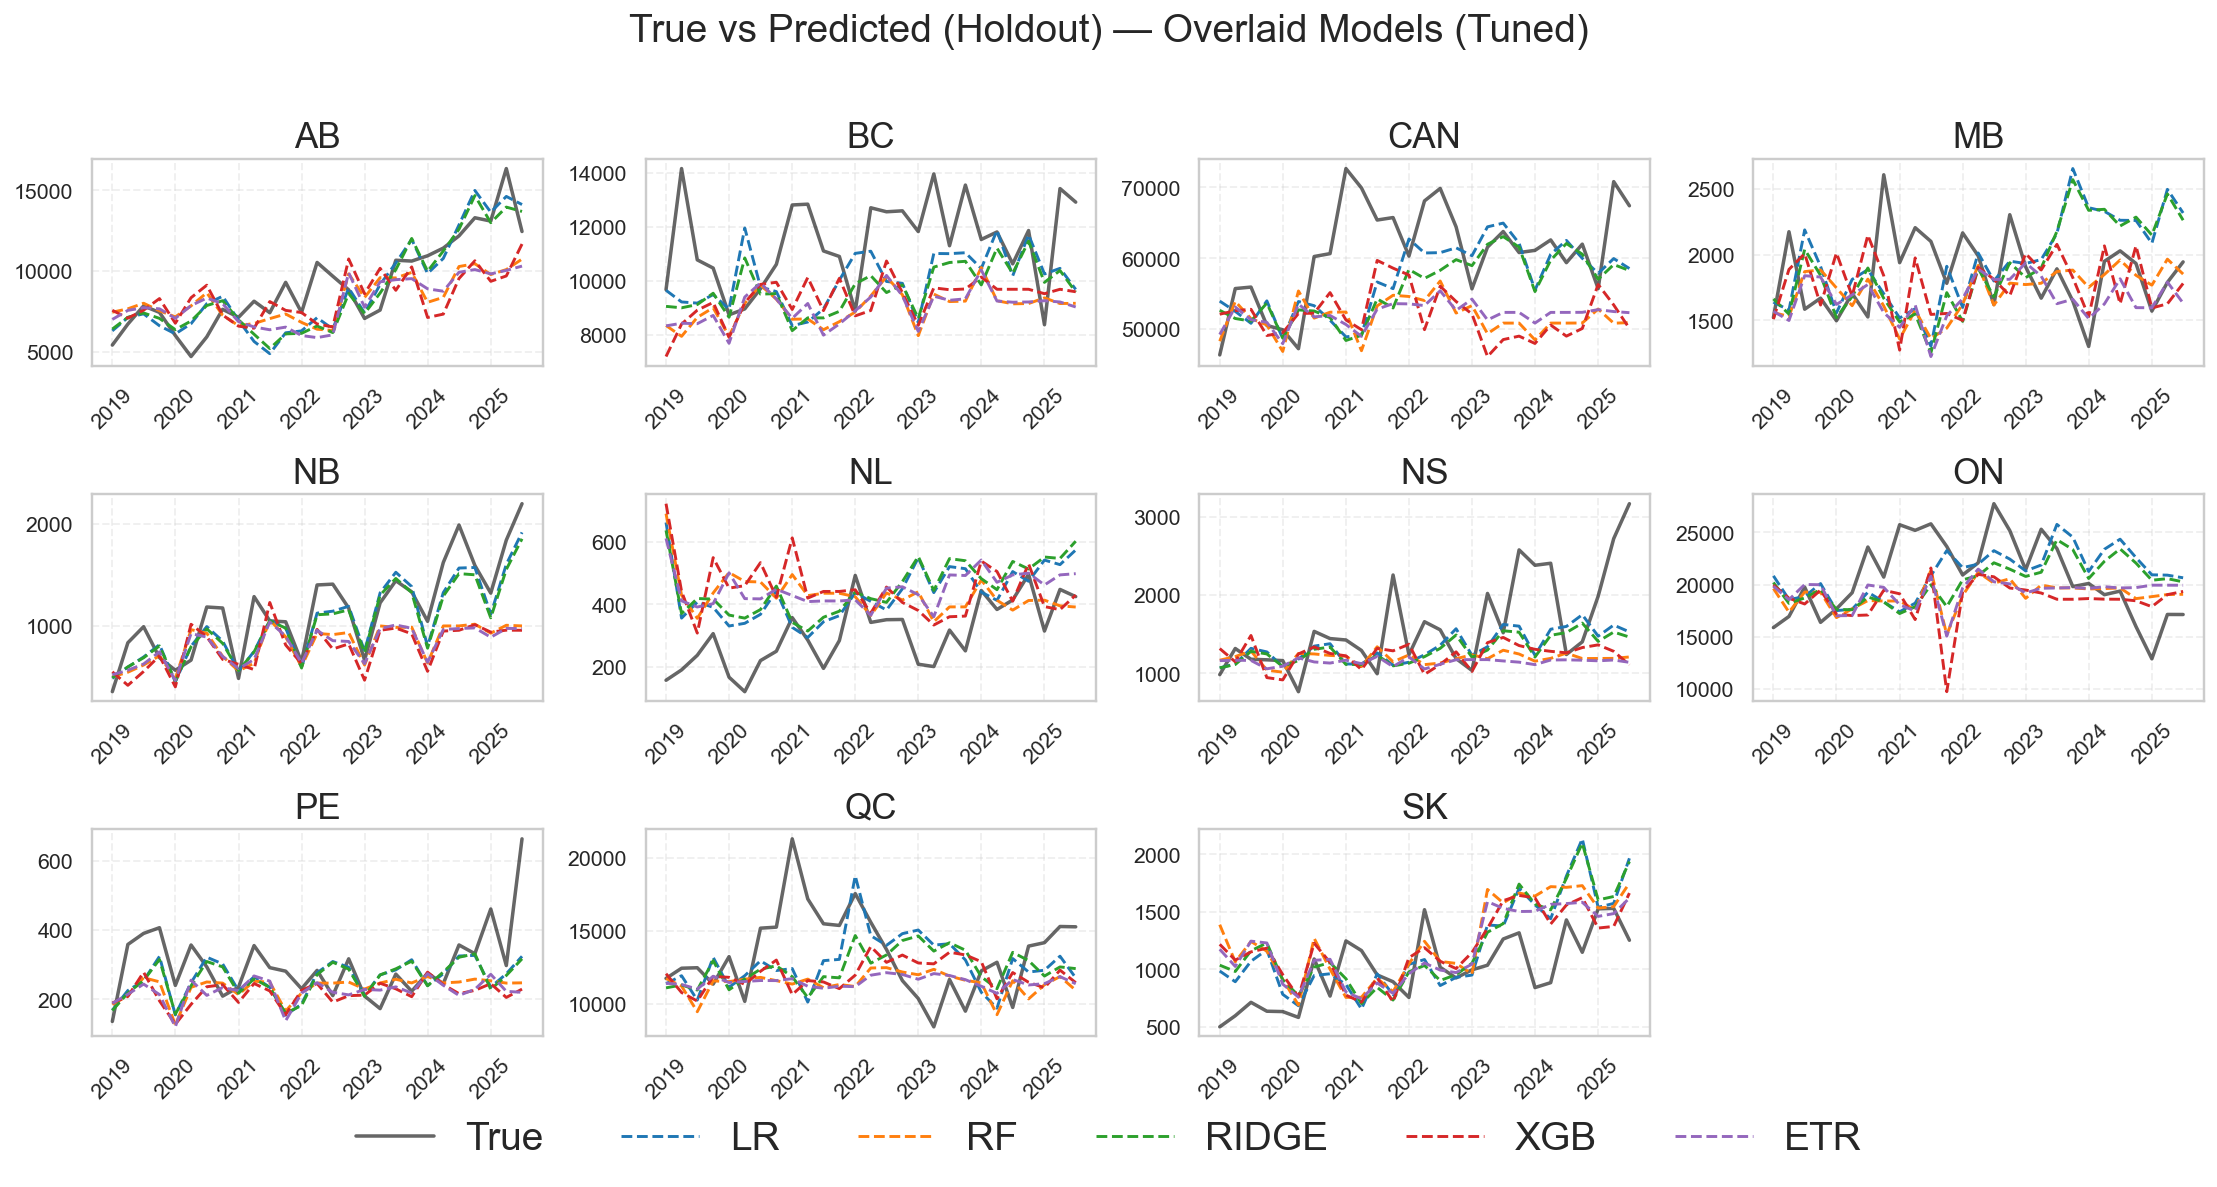

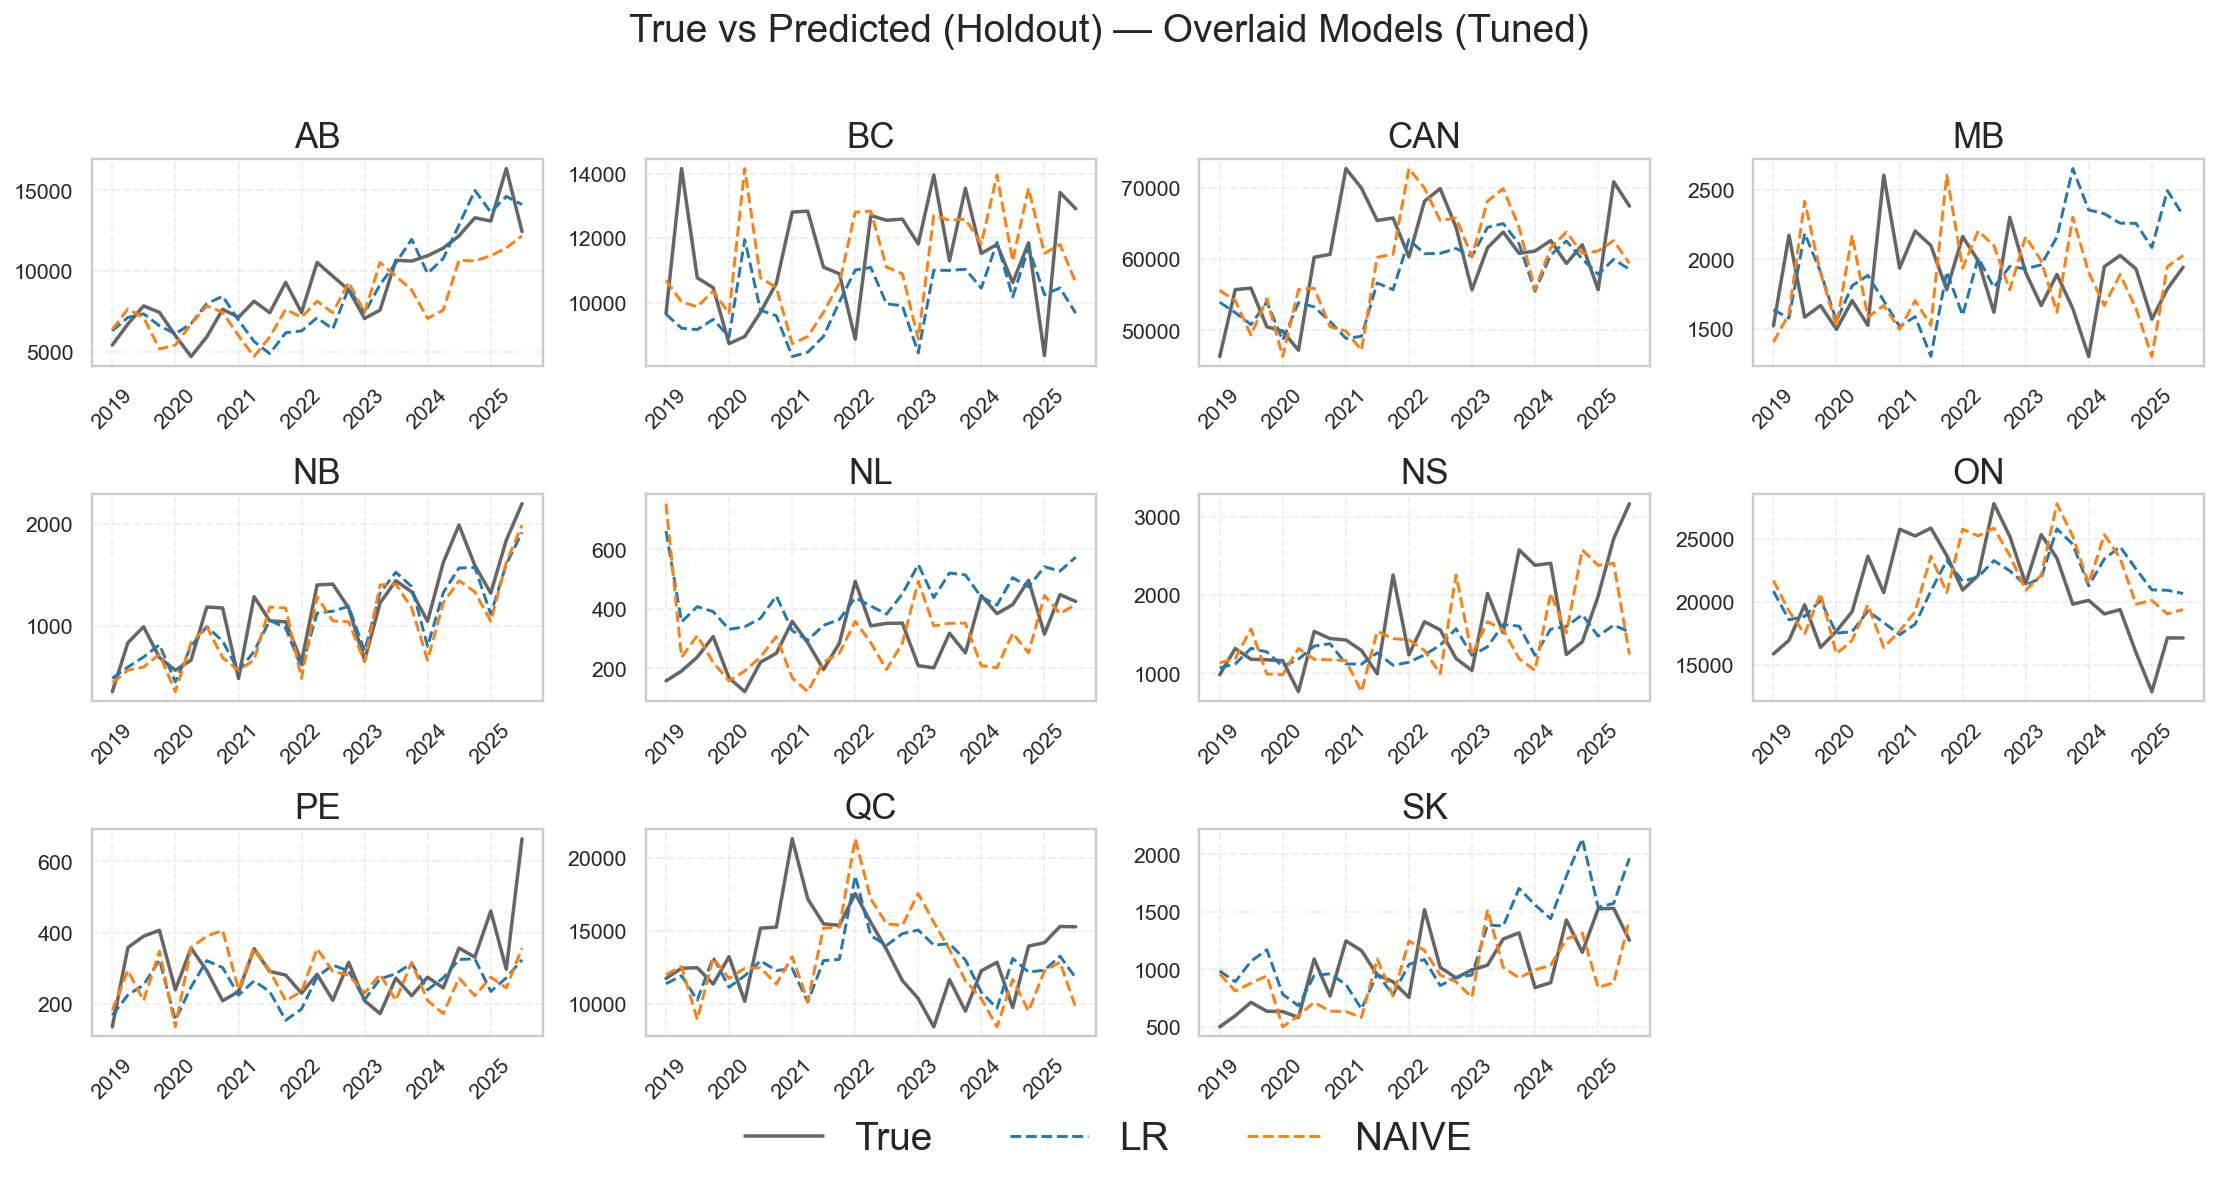

In [21]:

# Train–Test overlay (multiple models per province)
plot_holdout_overlay(preds_holdout_with_naive, ALL_MODELS)

plot_holdout_overlay(preds_holdout_with_naive, ['lr', 'naive'])


<large>
<b>Rolling Evaluation (Evolving Cutoff)</b>

Assess temporal stability by refitting models over multiple rolling cutoffs.  
This shows how model performance evolves as new data arrive and whether wins vs baseline persist.  
Parameters: <code>initial</code> starting cutoff, <code>step</code> cadence, <code>last_k_cutoffs</code> number of latest folds to visualize.
</large>


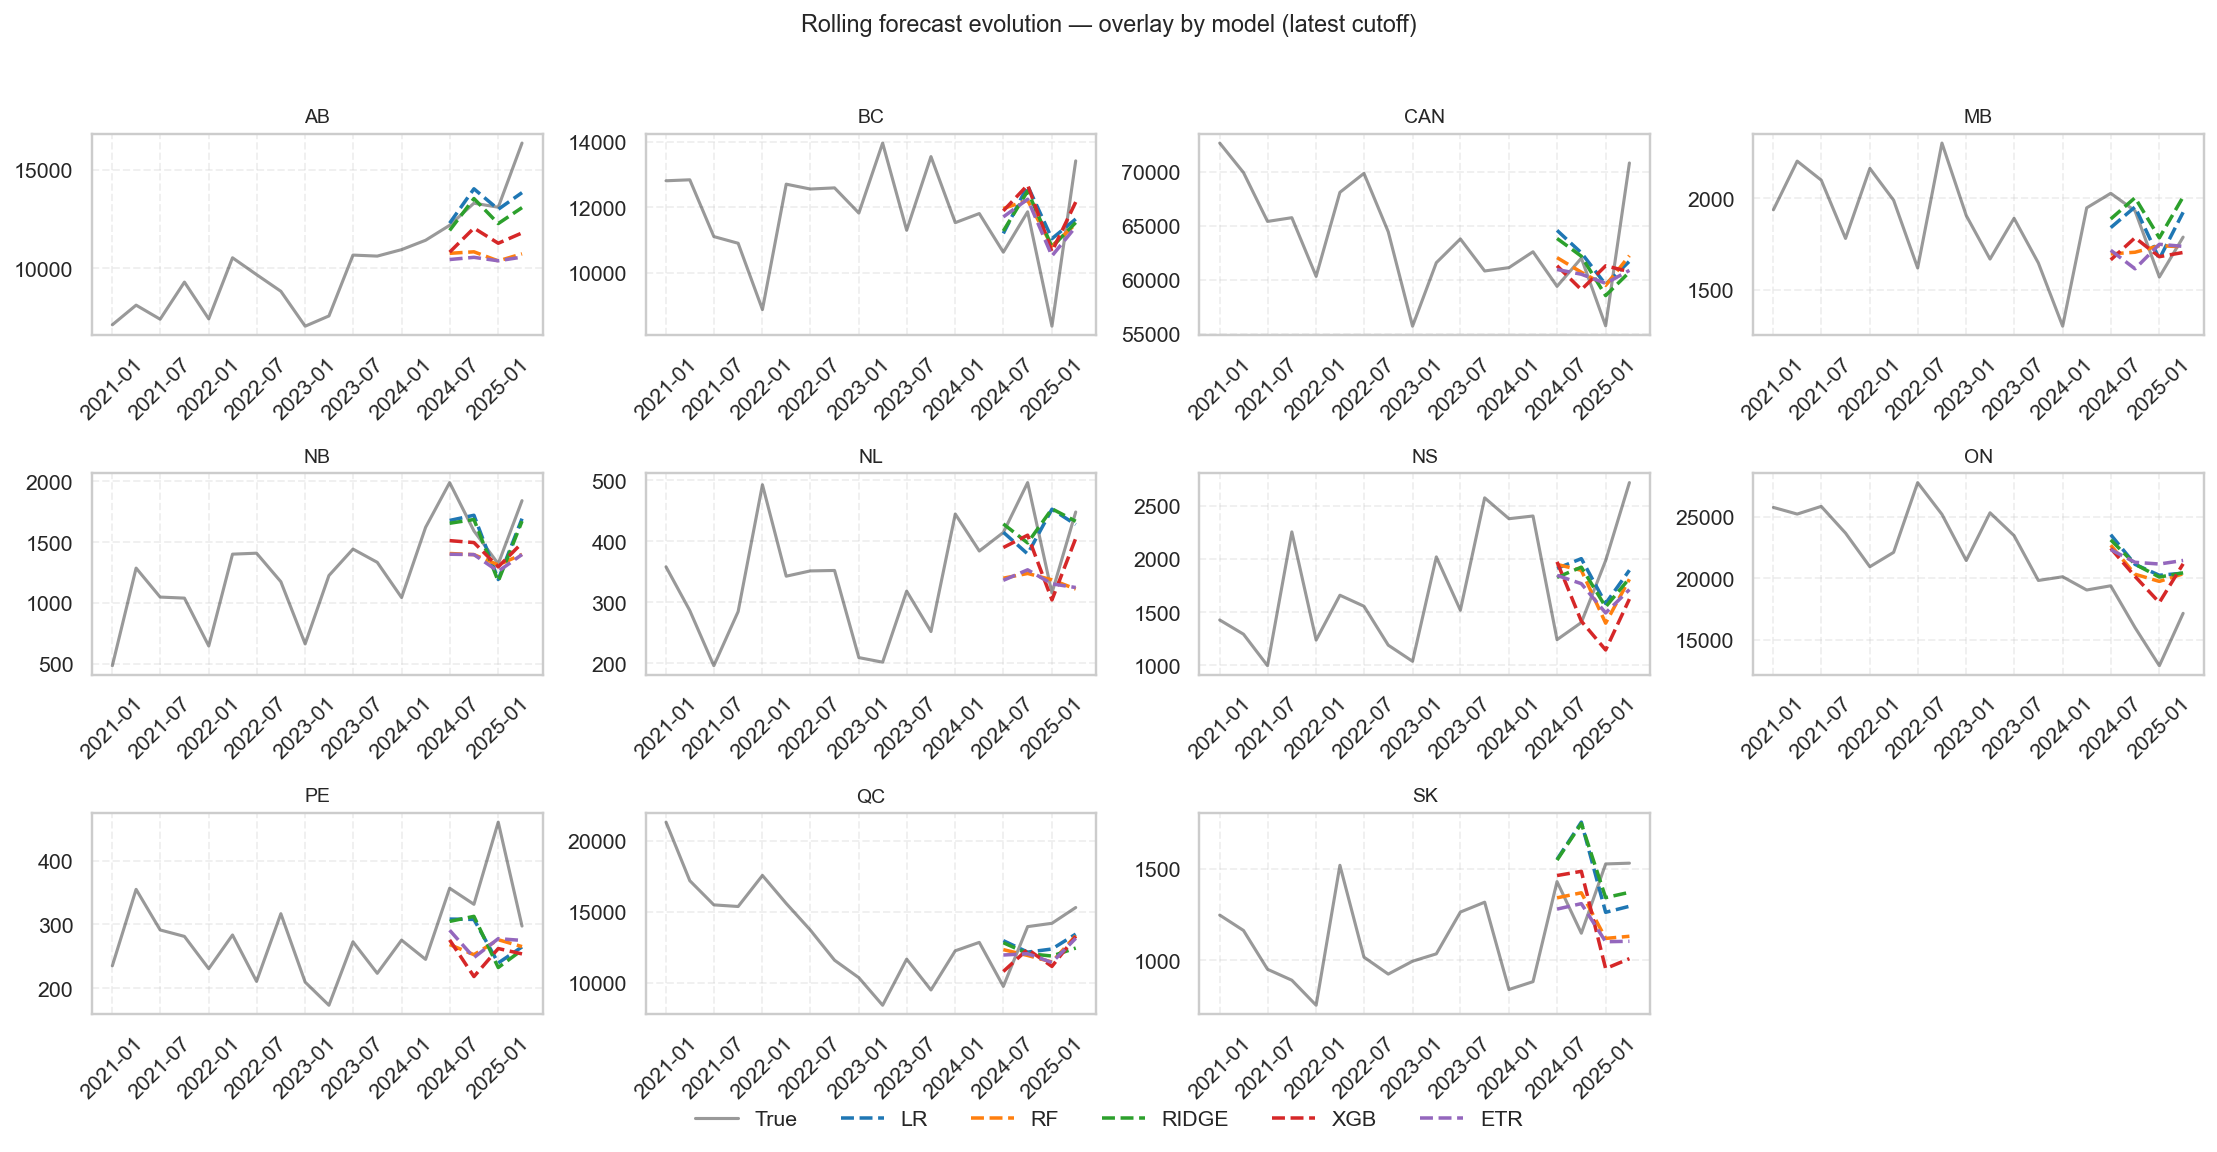

In [22]:

# Rolling evolution — latest cutoff overlay
preds_roll = rolling_evolution_overlay(
    df_all=safe_df,
    features=feat_cols,
    best_params=best_params,
    models_to_plot=ALL_MODELS,
    fh=H,
    initial="2012-12-31",
    step=2,                  # speed/coverage trade-off
    last_k_cutoffs=8,
    show_history=False,
    return_df=True,
)

naive_roll = add_naive_to_holdout(
    safe_df=safe_df, train_df=train, test_df=test,
    horizon=H, target_col="dwelling_starts"
)

preds_roll_with_naive = pd.concat([preds_roll, naive_roll], ignore_index=True)



<large>
<b>Rolling Stitched Lines</b>

For each quarter, keep the latest available forecast across folds to build a single stitched time series per model.  
This approximates “what would we have forecast at each quarter using only past data.”
</large>


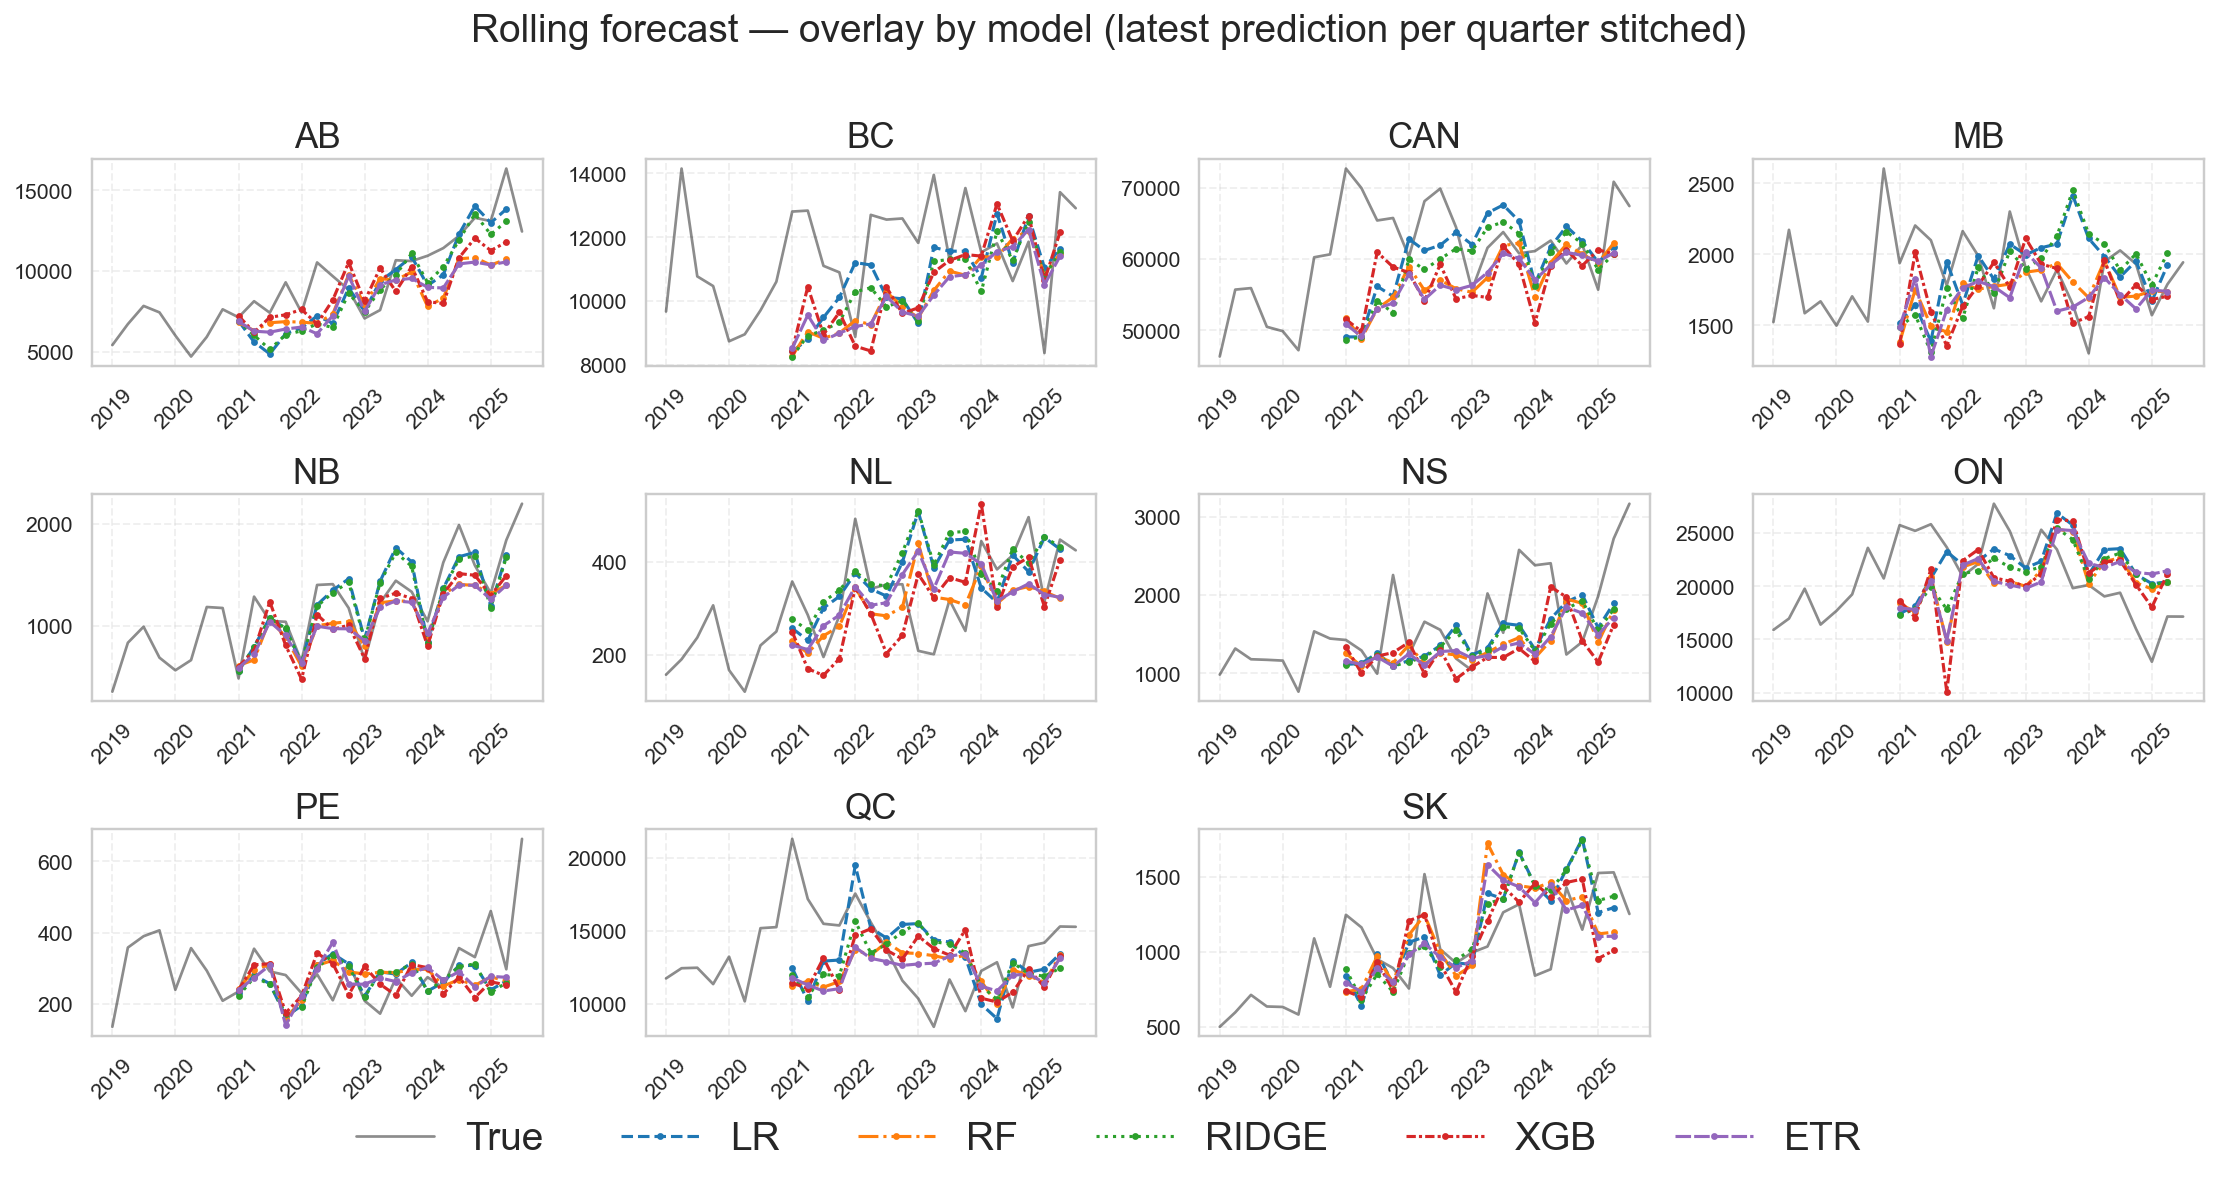

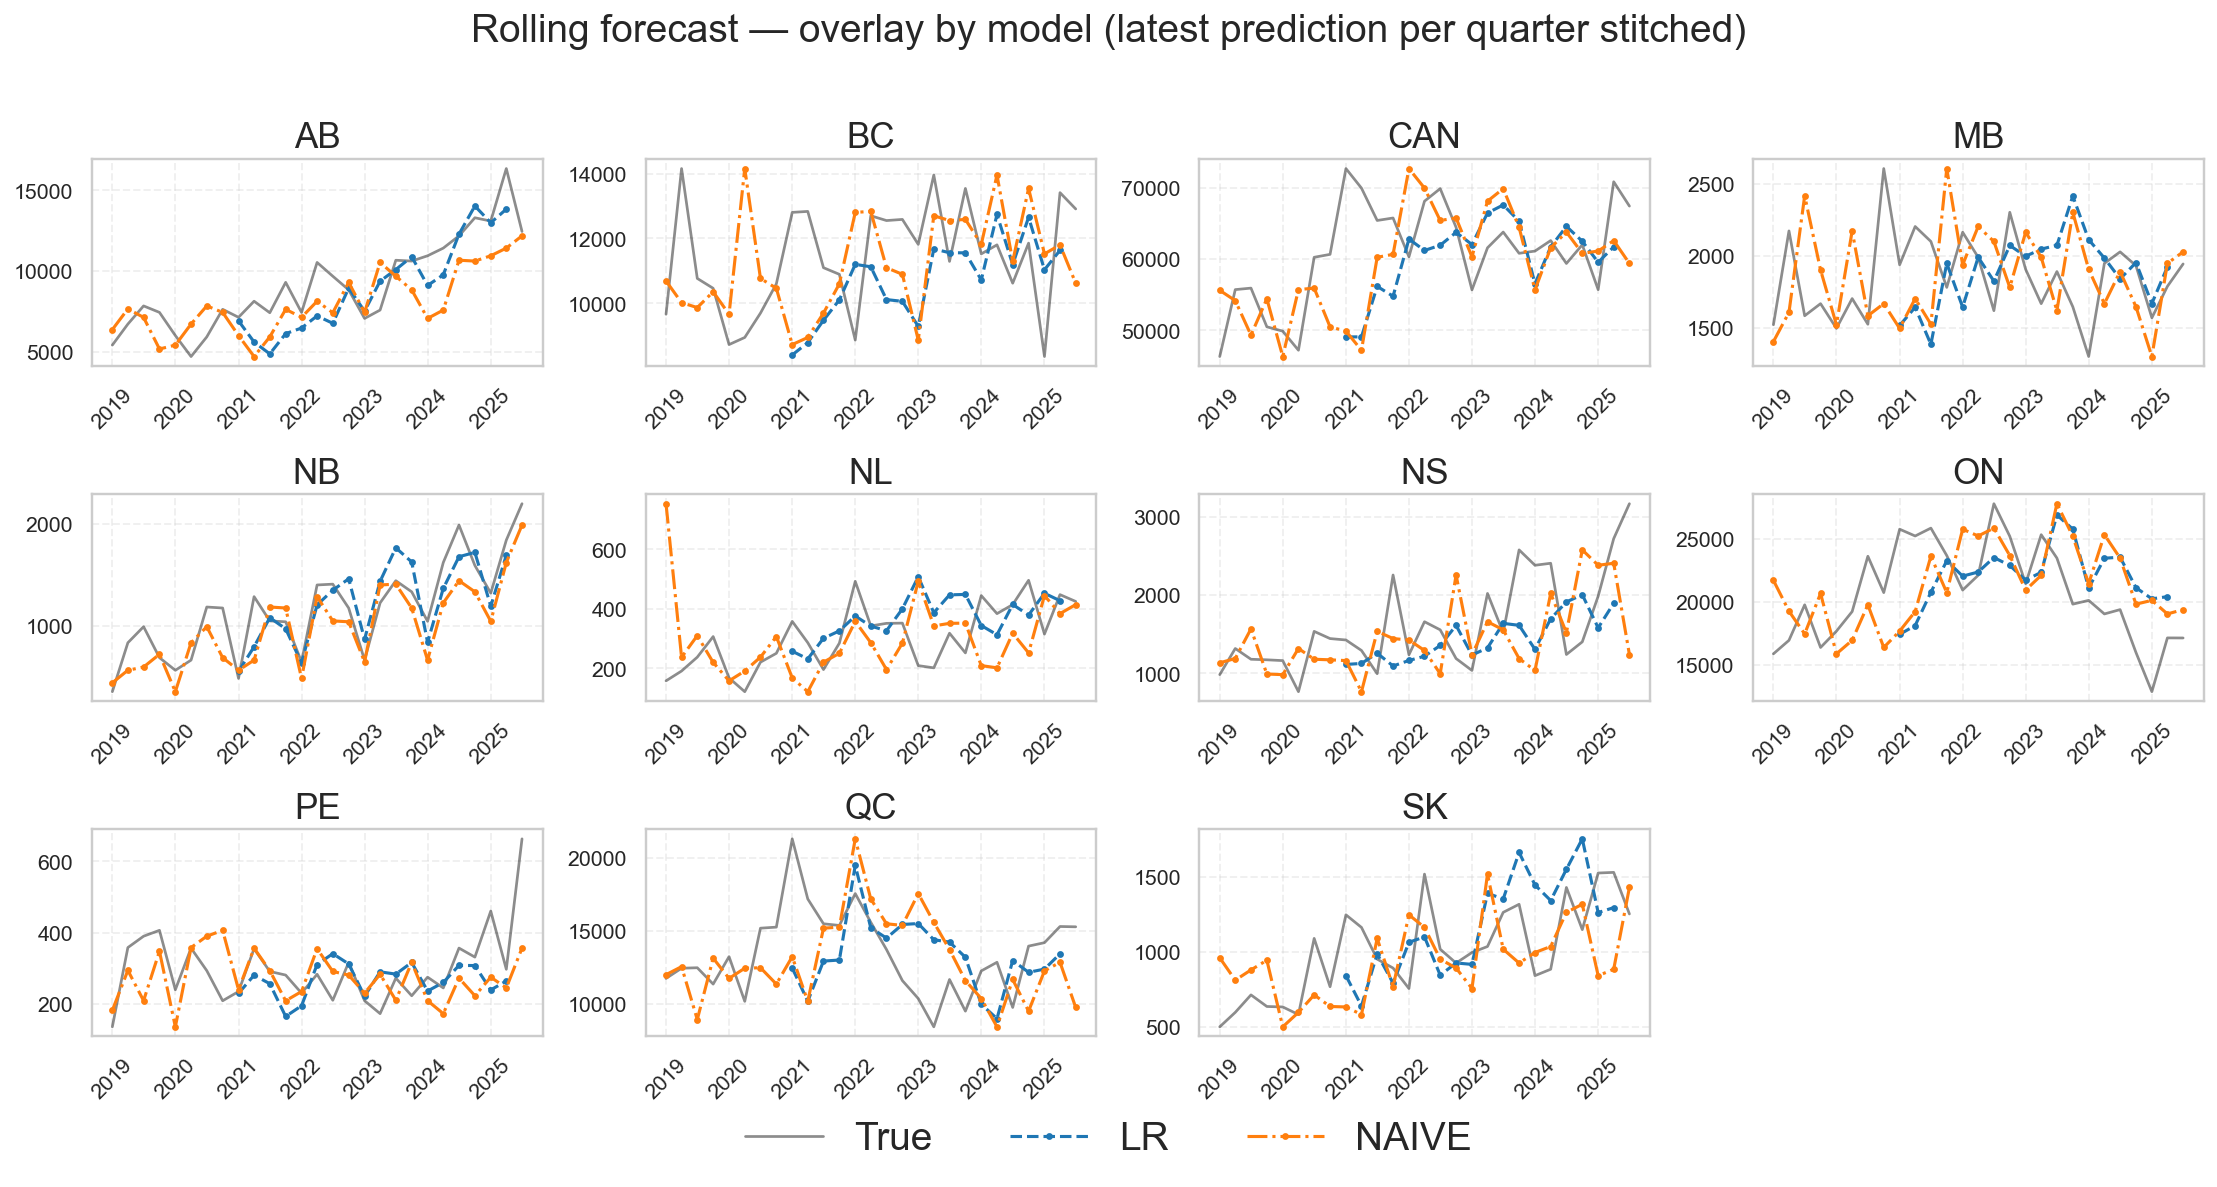

cutoff province model    quarter        y_true       y_pred  \
16  2020-10-01       ab   etr 2021-01-01   7120.583333  6864.252243   
17  2020-10-01       ab   etr 2021-04-01   8118.166667  6259.928959   
18  2020-10-01       ab   etr 2021-07-01   7404.166667  6210.101113   
19  2020-10-01       ab   etr 2021-10-01   9287.833333  6363.120515   
236 2021-04-01       ab   etr 2021-07-01   7404.166667  6199.075576   
237 2021-04-01       ab   etr 2021-10-01   9287.833333  6393.866100   
238 2021-04-01       ab   etr 2022-01-01   7420.750000  5971.097489   
239 2021-04-01       ab   etr 2022-04-01  10521.416667  5884.292858   
456 2021-10-01       ab   etr 2022-01-01   7420.750000  6515.567861   
457 2021-10-01       ab   etr 2022-04-01  10521.416667  6101.960790   

      MASE_denom  cut_rank  
16   1433.822917         0  
17   1433.822917         0  
18   1433.822917         0  
19   1433.822917         0  
236  1448.673246         1  
237  1448.673246         1  
238  1448.673246         1  
239  1448.673246         1  
456  1451.024425         2  
457  1451.024425         2

In [23]:

# Rolling stitched lines (latest per quarter across folds)
if preds_roll is not None:
    d_latest = latest_per_quarter(preds_roll_with_naive)
    rolling_overlay_lines(d_latest, ALL_MODELS)
    
if preds_roll is not None:
    d_latest = latest_per_quarter(preds_roll_with_naive)
    rolling_overlay_lines(d_latest, ['lr', 'naive'])

# Peek
preds_roll.head(10) if preds_roll is not None else None


<large>
<b>Performance Heatmaps (Holdout)</b>

Heatmaps of <code>MASE</code>, <code>MAE</code>, <code>RMSE</code>, and <code>sMAPE</code> across provinces and models.  
Centering MASE at 1 highlights improvements vs the seasonal-naïve baseline.
</large>


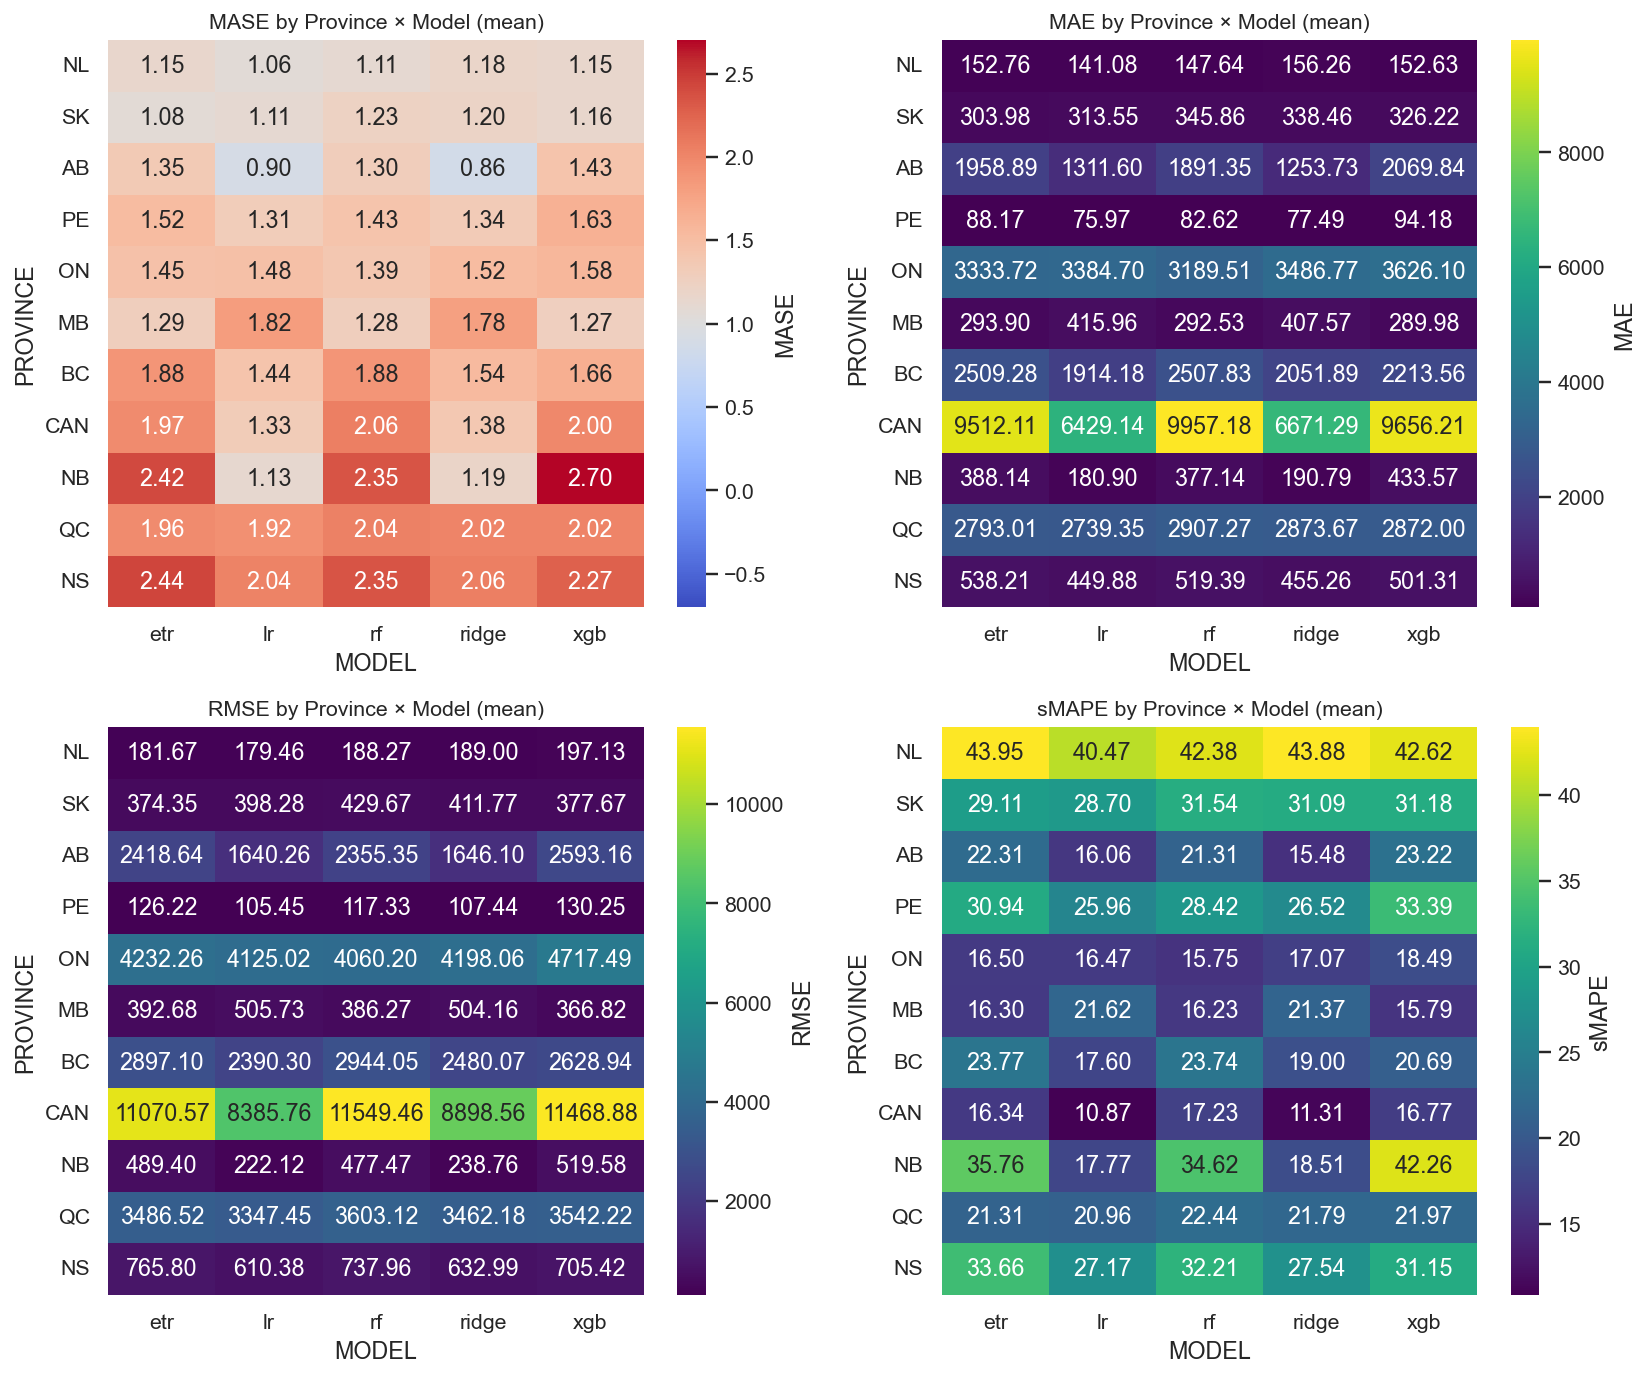

In [24]:
no_naive = preds_holdout_with_naive[preds_holdout_with_naive["model"].str.lower() != "naive"]
plot_perf_heatmaps_from_preds(
    preds_df=no_naive,
    metrics=("MASE","MAE","RMSE","sMAPE"),
    center_on_1=("MASE",),
    mase_fallback_to_existing_col=True
)


<large>
<b>Model Ranking (Holdout)</b>

Aggregate metrics by province and model; rank models (e.g., by mean MASE).  
Inspect the overall leaderboard and the best model per province to see consistent winners and regional differences.
</large>


In [25]:

per_prov_rank, leaderboard, best_by_prov = rank_models_across_provinces(
    preds_df=no_naive,
    metric="MASE",        # choose "MASE", "MAE", "RMSE", or "sMAPE"
    agg="mean",           # average across quarters per (province, model)
    rank_method="dense"
)

print("=== Overall leaderboard (by MASE) ===")
display(leaderboard)

print("=== Best model per province (by MASE) ===")
display(best_by_prov)

print("=== Full province–model ranking table ===")
display(per_prov_rank)

sameQ_hold_df = preds_holdout_with_naive.copy()

=== Overall leaderboard (by MASE) ===


model  wins  avg_rank  med_rank  mean_metric  n_provinces
0     LR     7  1.727273       1.0     1.412677           11
1  RIDGE     1  2.909091       2.0     1.460908           11
2     RF     1  3.363636       3.0     1.674758           11
3    ETR     1  3.363636       4.0     1.682377           11
4    XGB     1  3.636364       3.0     1.713990           11

=== Best model per province (by MASE) ===


province  model  metric_agg   n  rank
0        AB  ridge    0.863531  27   1.0
1        NL     lr    1.061235  27   1.0
2        SK    etr    1.078472  27   1.0
3        NB     lr    1.127101  27   1.0
4        MB    xgb    1.269885  27   1.0
5        PE     lr    1.312757  27   1.0
6       CAN     lr    1.328756  27   1.0
7        ON     rf    1.390649  27   1.0
8        BC     lr    1.437728  27   1.0
9        QC     lr    1.922741  27   1.0
10       NS     lr    2.036008  27   1.0

=== Full province–model ranking table ===


province  model  metric_agg   n  rank
0        AB  ridge    0.863531  27   1.0
1        AB     lr    0.903387  27   2.0
2        AB     rf    1.302707  27   3.0
3        AB    etr    1.349226  27   4.0
4        AB    xgb    1.425641  27   5.0
5        BC     lr    1.437728  27   1.0
6        BC  ridge    1.541157  27   2.0
7        BC    xgb    1.662590  27   3.0
8        BC     rf    1.883607  27   4.0
9        BC    etr    1.884698  27   5.0
10      CAN     lr    1.328756  27   1.0
11      CAN  ridge    1.378804  27   2.0
12      CAN    etr    1.965937  27   3.0
13      CAN    xgb    1.995719  27   4.0
14      CAN     rf    2.057923  27   5.0
15       MB    xgb    1.269885  27   1.0
16       MB     rf    1.281042  27   2.0
17       MB    etr    1.287039  27   3.0
18       MB  ridge    1.784842  27   4.0
19       MB     lr    1.821556  27   5.0
20       NB     lr    1.127101  27   1.0
21       NB  ridge    1.188761  27   2.0
22       NB     rf    2.349871  27   3.0
23       NB    etr    2.418393  27   4.0
24       NB    xgb    2.701427  27   5.0
25       NL     lr    1.061235  27   1.0
26       NL     rf    1.110605  27   2.0
27       NL    xgb    1.148143  27   3.0
28       NL    etr    1.149077  27   4.0
29       NL  ridge    1.175443  27   5.0
30       NS     lr    2.036008  27   1.0
31       NS  ridge    2.060353  27   2.0
32       NS    xgb    2.268751  27   3.0
33       NS     rf    2.350563  27   4.0
34       NS    etr    2.435773  27   5.0
35       ON     rf    1.390649  27   1.0
36       ON    etr    1.453526  27   2.0
37       ON     lr    1.475755  27   3.0
38       ON  ridge    1.520256  27   4.0
39       ON    xgb    1.581007  27   5.0
40       PE     lr    1.312757  27   1.0
41       PE  ridge    1.339008  27   2.0
42       PE     rf    1.427689  27   3.0
43       PE    etr    1.523597  27   4.0
44       PE    xgb    1.627501  27   5.0
45       QC     lr    1.922741  27   1.0
46       QC    etr    1.960407  27   2.0
47       QC    xgb    2.015850  27   3.0
48       QC  ridge    2.017022  27   4.0
49       QC     rf    2.040604  27   5.0
50       SK    etr    1.078472  27   1.0
51       SK     lr    1.112422  27   2.0
52       SK    xgb    1.157373  27   3.0
53       SK  ridge    1.200814  27   4.0
54       SK     rf    1.227076  27   5.0

<large>
<b>Rolling Metrics & Ranking</b>

Compute per-row metrics for rolling forecasts, drop the naïve rows, and generate heatmaps again.  
Rank models on rolling performance (e.g., by mean MASE) to confirm holdout conclusions are stable over time.
</large>


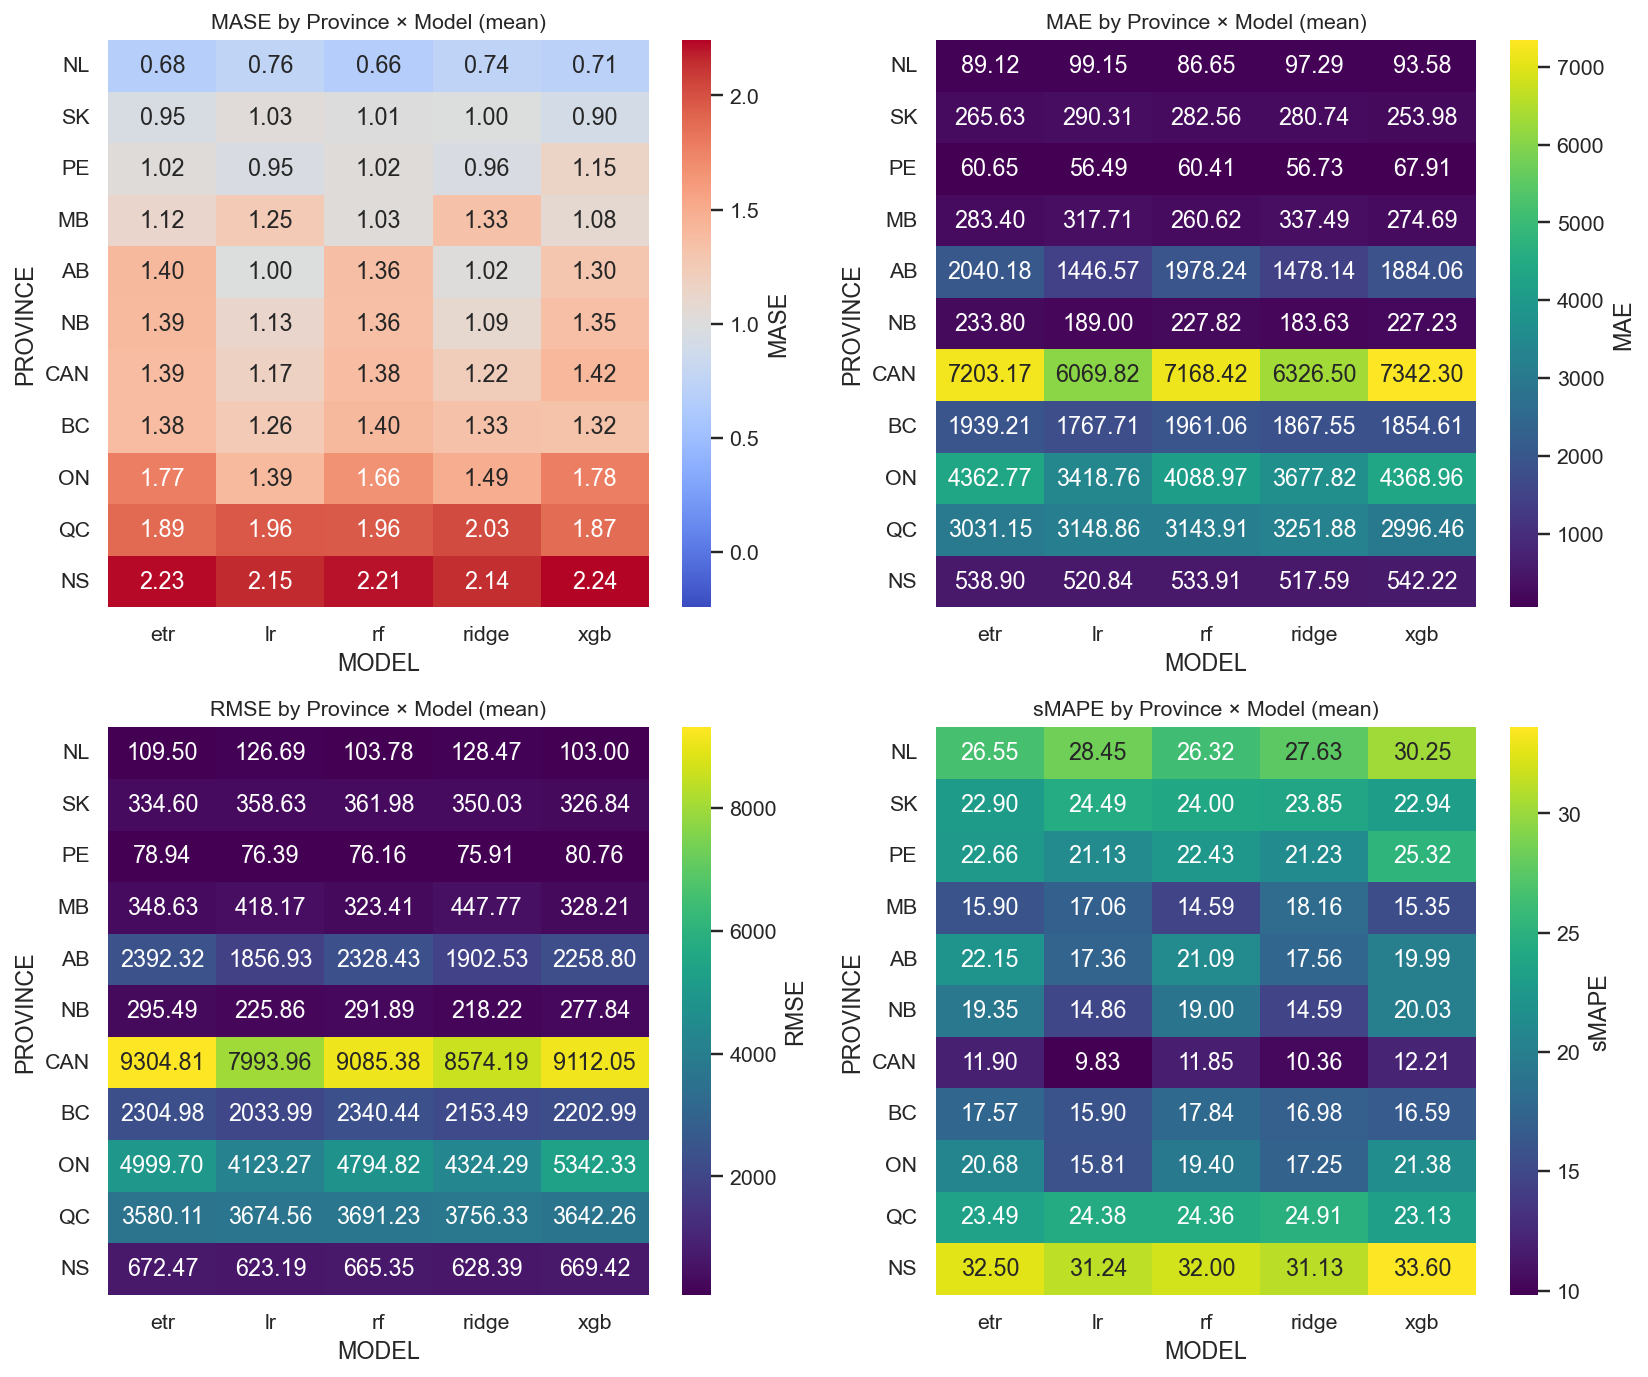

=== Overall leaderboard (by MASE) ===


model  wins  avg_rank  med_rank  mean_metric  n_provinces
0     LR     5  2.363636       2.0     1.282179           11
1  RIDGE     2  2.727273       2.0     1.310749           11
2     RF     2  3.181818       3.0     1.372645           11
3    XGB     2  3.181818       3.0     1.379774           11
4    ETR     0  3.545455       4.0     1.389376           11

=== Best model per province (by MASE) ===


province  model  metric_agg   n  rank
0        NL     rf    0.661367  32   1.0
1        SK    xgb    0.905247  32   1.0
2        PE     lr    0.954556  32   1.0
3        AB     lr    0.997898  32   1.0
4        MB     rf    1.041536  32   1.0
5        NB  ridge    1.093180  32   1.0
6       CAN     lr    1.185614  32   1.0
7        BC     lr    1.267179  32   1.0
8        ON     lr    1.390964  32   1.0
9        QC    xgb    1.901983  32   1.0
10       NS  ridge    2.128201  32   1.0

=== Full province–model ranking table ===


province  model  metric_agg   n  rank
0        AB     lr    0.997898  32   1.0
1        AB  ridge    1.018870  32   2.0
2        AB    xgb    1.295304  32   3.0
3        AB     rf    1.358706  32   4.0
4        AB    etr    1.401312  32   5.0
5        BC     lr    1.267179  32   1.0
6        BC    xgb    1.326807  32   2.0
7        BC  ridge    1.339516  32   3.0
8        BC    etr    1.389658  32   4.0
9        BC     rf    1.406131  32   5.0
10      CAN     lr    1.185614  32   1.0
11      CAN  ridge    1.236345  32   2.0
12      CAN     rf    1.394551  32   3.0
13      CAN    etr    1.401977  32   4.0
14      CAN    xgb    1.424083  32   5.0
15       MB     rf    1.041536  32   1.0
16       MB    xgb    1.096867  32   2.0
17       MB    etr    1.129416  32   3.0
18       MB     lr    1.261539  32   4.0
19       MB  ridge    1.339135  32   5.0
20       NB  ridge    1.093180  32   1.0
21       NB     lr    1.125062  32   2.0
22       NB    xgb    1.354404  32   3.0
23       NB     rf    1.356772  32   4.0
24       NB    etr    1.391905  32   5.0
25       NL     rf    0.661367  32   1.0
26       NL    etr    0.680406  32   2.0
27       NL    xgb    0.714251  32   3.0
28       NL  ridge    0.743070  32   4.0
29       NL     lr    0.757358  32   5.0
30       NS  ridge    2.128201  32   1.0
31       NS     lr    2.141050  32   2.0
32       NS     rf    2.187089  32   3.0
33       NS    etr    2.211402  32   4.0
34       NS    xgb    2.225724  32   5.0
35       ON     lr    1.390964  32   1.0
36       ON  ridge    1.500028  32   2.0
37       ON     rf    1.667797  32   3.0
38       ON    etr    1.778153  32   4.0
39       ON    xgb    1.783874  32   5.0
40       PE     lr    0.954556  32   1.0
41       PE  ridge    0.958545  32   2.0
42       PE     rf    1.021809  32   3.0
43       PE    etr    1.024886  32   4.0
44       PE    xgb    1.148966  32   5.0
45       QC    xgb    1.901983  32   1.0
46       QC    etr    1.927410  32   2.0
47       QC     lr    1.988346  32   3.0
48       QC     rf    1.996445  32   4.0
49       QC  ridge    2.061106  32   5.0
50       SK    xgb    0.905247  32   1.0
51       SK    etr    0.946605  32   2.0
52       SK  ridge    1.000243  32   3.0
53       SK     rf    1.006894  32   4.0
54       SK     lr    1.034400  32   5.0

In [26]:
no_naive = preds_roll_with_naive[preds_roll_with_naive["model"].str.lower() != "naive"]

plot_perf_heatmaps_from_preds(
    preds_df=no_naive,
    metrics=("MASE","MAE","RMSE","sMAPE"),
    center_on_1=("MASE",),
    mase_denom_col="MASE_denom"
)

roll_scored = add_row_metrics_for_rolling(preds_roll_with_naive)
roll_scored = roll_scored[roll_scored["model"].str.lower() != "naive"]

per_prov_rank, leaderboard, best_by_prov = rank_models_across_provinces(
    preds_df=roll_scored,
    metric="MASE",        # choose "MASE", "MAE", "RMSE", or "sMAPE"
    agg="mean",           # average across quarters per (province, model)
    rank_method="dense"
)

print("=== Overall leaderboard (by MASE) ===")
display(leaderboard)

print("=== Best model per province (by MASE) ===")
display(best_by_prov)

print("=== Full province–model ranking table ===")
display(per_prov_rank)

sameQ_roll_df = roll_scored.copy()